# Проект 8.
# Прогнозирование времени поездки на такси

## 1. Постановка задачи

  
Нужно решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Нужно построить модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в Data Science соревновании.
Во время выполнения проекта будем работать с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
import warnings
warnings.filterwarnings('ignore')

Прочитаем наш файл с исходными данными:

In [5]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Разделим признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 


### Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [6]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
print('Мин дата: {}'.format(taxi_data['pickup_datetime'].min()))
print('Макс дата: {}'.format(taxi_data['pickup_datetime'].max()))

Мин дата: 2016-01-01 00:00:17
Макс дата: 2016-06-30 23:59:39


Посмотрим на пропуски. 

In [7]:
taxi_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [8]:
taxi_data.describe()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,2016-04-01 10:10:24.940037120,2016-04-01 10:26:24.432310528,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
min,1.000000e+00,2016-01-01 00:00:17,2016-01-01 00:03:31,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,2016-02-17 16:46:04.249999872,2016-02-17 17:05:32.500000,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,2016-04-01 17:19:40,2016-04-01 17:35:12,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2016-05-15 03:56:08.750000128,2016-05-15 04:10:51.750000128,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,2016-06-30 23:59:39,2016-07-01 23:02:03,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06
std,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03


Посмотрим на статистические характеристики некоторых признаков. 
В данных представлены два таксопарка.   
Медианное значение количества пассажиров - 1, среднее значение смещено к двум, вероятно на среднее значение влияет правый хвост распределения, обязательно нужно взглянуть на распределение этого признака и выбросы.  
Медианная длительность поездки составляет 662 секунды, а средняя - 959 секунд. Минимальное время поездки составило 1 секунду, это яновно аномальное значение, а не реальная поездка. Максимальная поездка составила 3526282 секунды, что конечноже тоже является аномалией.

Чтобы однозначно обозначить такие записи в таблице как выбросы, нам необходимо произвести более глубокий анализ данных с подключением дополнительной информации.

На основе полученной статистической информации о целевом признаке trip_duration также делаем важный вывод, что использование среднего в качестве центральной меры распределения длительности поездок будет грубой ошибкой. Лучше всего подойдут меры, не зависящие от выбросов, такие как усечённое среднее, логарифмическое среднее или медиана. При проведении исследований будем использовать медиану, а наша метрика качества моделей будет завязана на логарифмическом среднем.

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.
Так как все манипуляции над данными мы будем применять как с тренировочным, так и с тестовым набором данных, во избежание дублирования кода мы будем производить предобработку с помощью функций. Также применение функций позволит сделать код гораздо более эстетичным и читабельным.


Начнём с временных характеристик. Хранить дату и время в формате datetime как категориальный признак смысла не имеет, поэтому вытащим из нее полезную информацию.

Создадим функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.


In [9]:
def add_datetime_features(df):
    # Извлекаем дату (без времени)
    df['pickup_date'] = df['pickup_datetime'].dt.date
    # Извлекаем час
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
     # Извлекаем день недели (понедельник=0, воскресенье=6)
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    return df

taxi_data = add_datetime_features(taxi_data)

От того, является ли день праздничным, часто зависит ситуация на дорогах. Большое количество автомобилей создаёт пробки и потенциально увеличивает длительность совершаемой на такси поездки.
Добавим в наш датасет информацию о том, является ли день праздничным. Подгрузим таблицу с датами всех праздничных дней в Америке за 2016 год. Данные представлены в табличном формате CSV и содержат три столбца:

day — день недели;
date — дата;
holiday — наименование праздника.

Создадим функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 


In [10]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
holiday_data.head(3)

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday


In [11]:
def add_holiday_features(df,df_holiday):
    df['pickup_date'] = pd.to_datetime(df['pickup_date'])
    df_holiday['date'] = pd.to_datetime(df_holiday['date'])
    df['pickup_holiday'] = df['pickup_date'].isin(df_holiday['date']).astype('int')
    return df

taxi_data = add_holiday_features(taxi_data,holiday_data)

Теперь переходим к географическим характеристиками.
В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации.
Например, зная широту и долготу начальной и конечной точек маршрута, можем воспользоваться OSRM API.
Подгрузим таблицу из OSRM для поездок из тренировочной таблицы. Наборы данных представлены в табличном формате CSV.
 Нас будут интересовать только следующие столбцы:
* id — идентификатор поездки;
* total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
* number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

Создадим функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [12]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')

def add_osrm_features(df,df_osrm):
    df = df.merge(df_osrm[['id','total_distance','total_travel_time','number_of_steps']], how='left', on = 'id')
    return df

taxi_data = add_osrm_features(taxi_data,osrm_data)


In [13]:
# Посмотрим есть ли пропуски
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 18 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int32         
 13  pickup_day_o

Посмотрим, есть ли разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM

In [14]:
(taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median()).round()

372.0

Да, разница есть и это объяснимо, ведь время поездки, вычисляемое с помощью OSRM, не является истинным временем поездки, так как оно вычисляется по кратчайшему пути при идеальных условиях: отсутствие пробок, погодных влияний и других внешних факторов. 

In [15]:
taxi_data[taxi_data.isna().any(axis=1)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,pickup_holiday,total_distance,total_travel_time,number_of_steps
1133561,id3008062,2,2016-06-23 19:04:09,2016-06-23 19:04:35,1,-73.787537,40.64241,-73.787811,40.642109,N,26,2016-06-23,19,3,0,NaN,NaN,NaN


С помощью географических характеристик можно извлечь ещё немного информации. Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере, а также узнать направление движения автомобиля.  
Введём в наш анализ расстояние по формуле гаверсинуса.   
Данная формула определяет кратчайшее расстояние между двумя точками на сфере, если известны широта и долгота каждой из точек. Геометрически это длина кратчайшей дуги, связывающей точки на сфере.  
Также зная начальную и конечную точку маршрута, мы можем вычислить направление движения автомобиля (угол пеленга).  
Вычислим эти параметры через функции:

In [16]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Создалим функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.


In [17]:
def add_geographical_features(df):
    lat1 = df['pickup_latitude']
    lng1 = df['pickup_longitude']
    lat2 = df['dropoff_latitude']
    lng2 = df['dropoff_longitude']
    df['haversine_distance'] = get_haversine_distance(lat1, lng1, lat2, lng2)
    df['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)
    return df

taxi_data = add_geographical_features(taxi_data)

Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

Гипотеза состоит в том, что длительность поездки будет зависеть от того, к какому географическому кластеру будет принадлежать поездка.

В качестве метода кластеризации воспользуемся алгоритмом K-Means. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.


Создадим функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [18]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)
taxi_data['geo_cluster'] = kmeans.labels_ 
def add_cluster_features(df, kmeans):
    # Создаем матрицу координат для новых данных
    coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                        df[['dropoff_latitude', 'dropoff_longitude']]))
    
    # ПРЕДСКАЗЫВАЕМ кластеры для новых данных
    df['geo_cluster'] = kmeans.predict(coords)
    return df



Другим важным фактором, потенциально влияющим на дорожное движение, является погода. Так, например, логично предположить, что снег и дождь могут затруднять движение и увеличивать время поездки.
Подгрузим таблицу, содержащую информацию о погодных условиях в Нью-Йорке в 2016 году. Датасет представлен в табличном формате CSV. Нас будут интересовать только следующие столбцы:

* time — дата измерения (с интервалом в час);
* temperature — температура;
* visibility — видимость;
* wind speed — средняя скорость ветра;
* precip — количество осадков;
* events — погодные явления: Rain — дождь, Snow — снег, Fog — туман, None — отсутствие погодных явлений.

Создадим функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [19]:
weather_data = pd.read_csv('data/weather_data.csv')

def add_weather_features(df, df_weather):
    # Преобразуем время
    df_weather['time'] = pd.to_datetime(df_weather['time'])
    # Создаем признаки для соединения
    df_weather['pickup_date'] = pd.to_datetime(df_weather['time'].dt.date)
    df_weather['pickup_hour'] = df_weather['time'].dt.hour
    # Выделяем столбцы для объединения
    cols_for_merge = ['pickup_date','pickup_hour','temperature','visibility','wind speed','precip','events']
    # Объединяем таблицы
    df = df.merge(df_weather[cols_for_merge], how = 'left', on = ['pickup_date','pickup_hour'])
    return df

taxi_data = add_weather_features(taxi_data,weather_data)

In [20]:
taxi_data['events'].isna().sum()

1387217

In [21]:
taxi_data['events'].value_counts()

events
Rain    58300
Snow    13126
Fog         1
Name: count, dtype: int64

In [23]:
taxi_data[['temperature','visibility','wind speed','precip']].isna().any(axis=1).sum()

12032

В результате объединения мы получили записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

In [24]:
rows_with_null = taxi_data[['temperature','visibility','wind speed','precip']].isna().any(axis=1).sum()
all_rows = taxi_data.shape[0]
percentage = round((rows_with_null/all)*100,2)
percentage


0.82

Теперь, когда мы расширили датасет новыми признаками, необходимо немного его подчистить.
В результате добавления новой информации у нас появились пропущенные значения в данных.
Благодаря новым добавленным признакам мы сможем более детально изучить поездки с аномальной длительностью.

Создадим функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. 
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 


In [25]:
def fill_null_weather_data(df):
    # Для всех погодных столбцов
    weather_columns = ['temperature', 'visibility', 'wind speed', 'precip']
    for col in weather_columns:
        df[col] = df[col].fillna(
        df.groupby('pickup_date')[col].transform('median')
        )
   
    df['events'] = df['events'].fillna('None')
    df['total_distance'] = df['total_distance'].fillna(df['total_distance'].median())
    df['total_travel_time'] = df['total_travel_time'].fillna(df['total_travel_time'].median())
    df['number_of_steps'] = df['number_of_steps'].fillna(df['number_of_steps'].median())
    return df

taxi_data = fill_null_weather_data(taxi_data)

In [26]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
 11  pickup_date         1458644 non-null  datetime64[ns]
 12  pickup_hour         1458644 non-null  int32         
 13  pickup_day_o

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Примем, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Будем считать выбросами только последнюю группу. 
Для этого вычислим среднюю скорость автомобиля на кратчайшем пути следующим образом и построим диаграмму рассеяния средней скорости движения автомобилей.


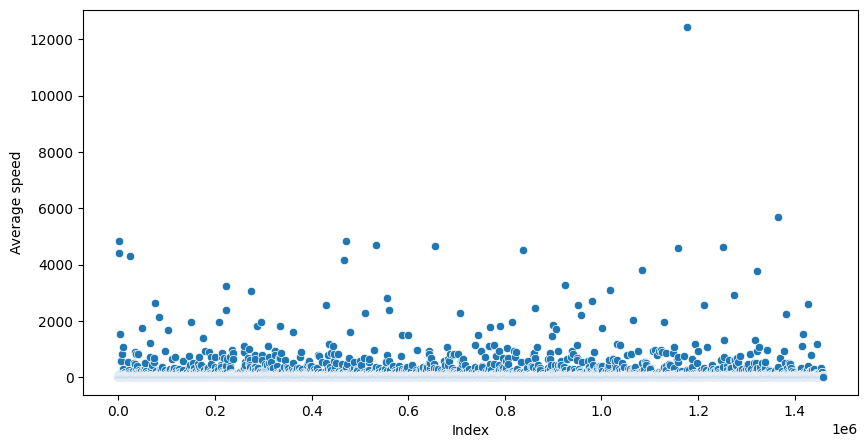

In [27]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч.
Примем, что предельная средняя скорость, которую могут развивать таксисты будет 200 км/ч. 


In [ ]:
# Удалим поездки, длительность которых превышает 24 часа
taxi_data = taxi_data[~(taxi_data['trip_duration']>24*60*60)]

In [ ]:
#  Удалим поездки со средней скоростью более 200 км/ч
taxi_data = taxi_data[avg_speed <= 200]

## 3. Разведывательный анализ данных (EDA)

В этой части проекта:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним анализ визуализациями, иллюстрирующими исследование.

Начинаем с целевого признака. За основную метрику качества решения поставленной задачи примем RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [30]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 

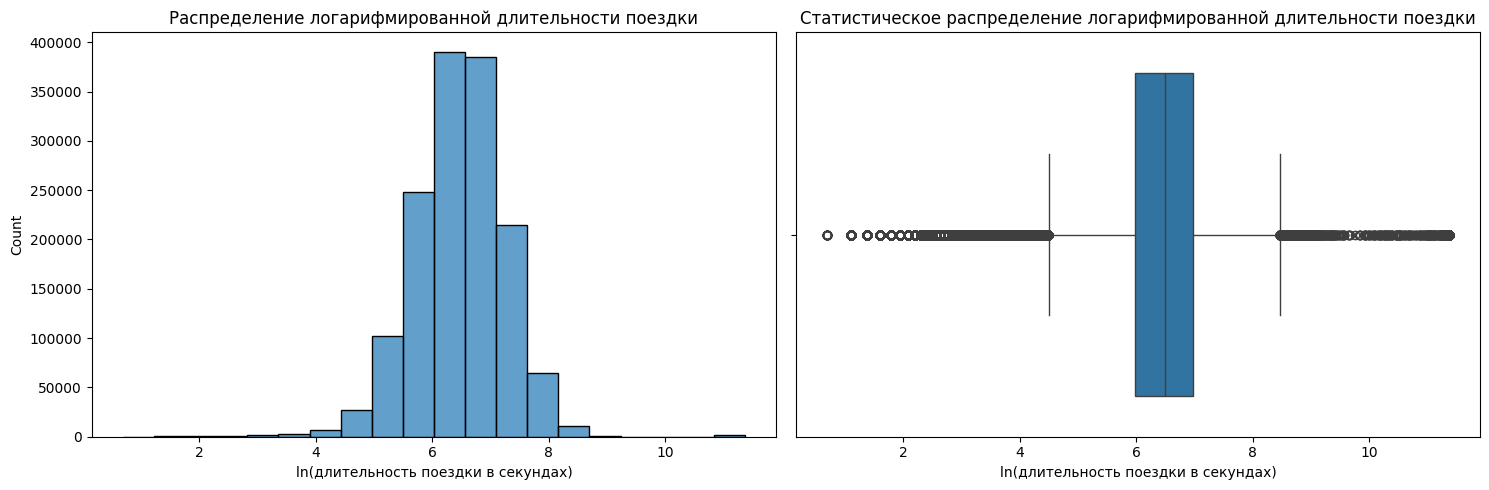

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
histplot = sns.histplot(data=taxi_data, x='trip_duration_log', ax=axes[0], alpha=0.7, bins=20, kde=False)
histplot.set_title('Распределение логарифмированной длительности поездки')
histplot.set_xlabel('ln(длительность поездки в секундах)')
boxplot = sns.boxplot(data=taxi_data, x='trip_duration_log', ax=axes[1])
boxplot.set_title('Статистическое распределение логарифмированной длительности поездки')
boxplot.set_xlabel('ln(длительность поездки в секундах)')
plt.tight_layout() #выравнивание графиков

Проверим, является ли полученное распределение нормальным с помощью теста Д'Агостино-Пирсона.
Выдвенем гипотезы:  
Ho - распределение нормальное  
H1 - распределение не нормальное

In [32]:
import scipy.stats as stats

# задаём уровень значимости
alpha = 0.05 

# загружаем данные
data = taxi_data['trip_duration_log']

statistic, p_value = stats.normaltest(data)

# Тест Д'Агостино-Пирсона
print(f'Статистика теста: {statistic:.3f}')
print(f'p-value = {p_value:.3f}')

# интерпретируем результат
if p_value <= alpha:
    print('Отвергаем нулевую гипотезу: распределение НЕ нормальное')
else:
    print('Не отвергаем нулевую гипотезу: распределение нормальное')

Статистика теста: 138350.166
p-value = 0.000
Отвергаем нулевую гипотезу: распределение НЕ нормальное


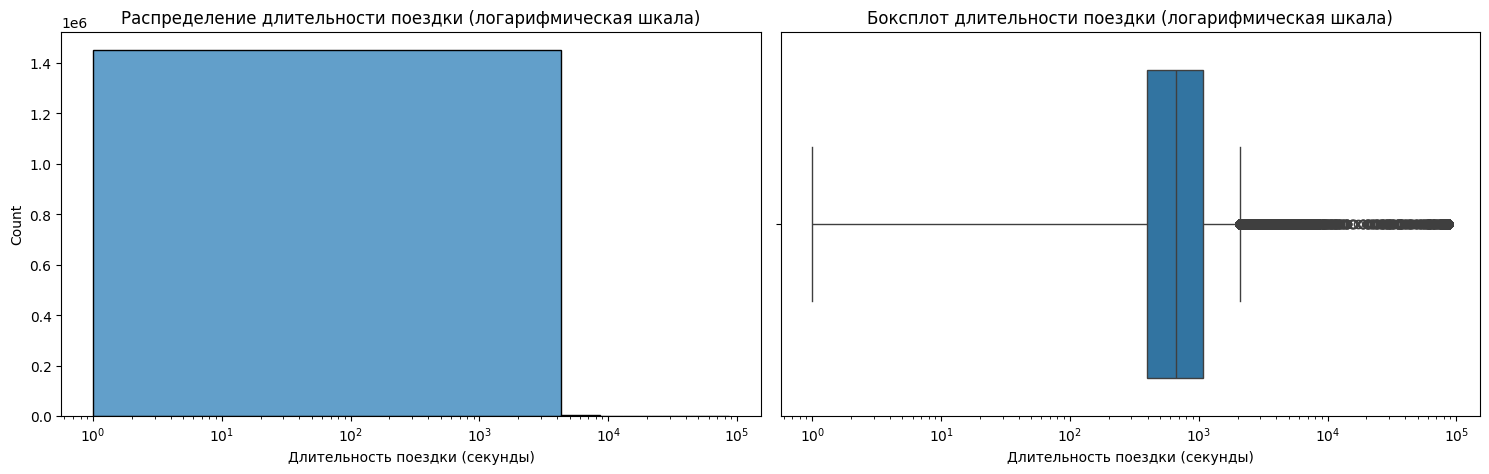

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма с логарифмической шкалой (без преобразования данных)
histplot = sns.histplot(data=taxi_data, x='trip_duration', ax=axes[0], alpha=0.7, bins=20, kde=False)
histplot.set_xscale('log')
histplot.set_title('Распределение длительности поездки (логарифмическая шкала)')
histplot.set_xlabel('Длительность поездки (секунды)')

# Боксплот с логарифмической шкалой
boxplot = sns.boxplot(data=taxi_data, x='trip_duration', ax=axes[1])
boxplot.set_xscale('log')
boxplot.set_title('Боксплот длительности поездки (логарифмическая шкала)')
boxplot.set_xlabel('Длительность поездки (секунды)')

plt.tight_layout()

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

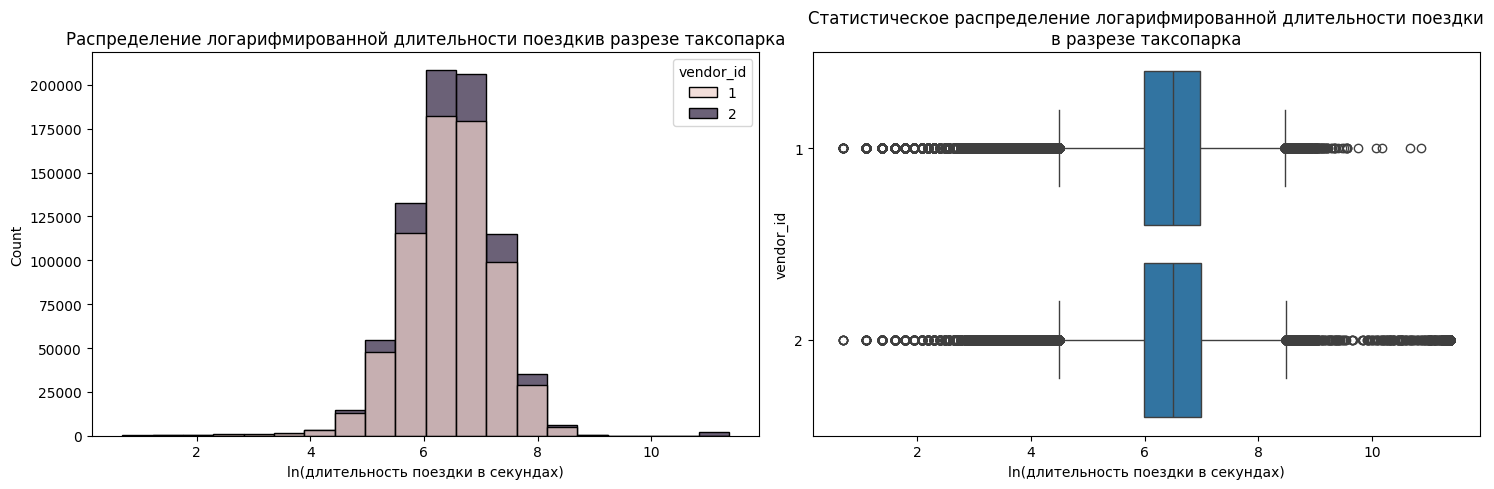

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
histplot = sns.histplot(data=taxi_data, x='trip_duration_log', ax=axes[0], alpha=0.7, bins=20, kde=False, hue='vendor_id')
histplot.set_title('Распределение логарифмированной длительности поездкив разрезе таксопарка')
histplot.set_xlabel('ln(длительность поездки в секундах)')
boxplot = sns.boxplot(data=taxi_data, x='trip_duration_log', y='vendor_id', ax=axes[1], orient='h')
boxplot.set_title('Статистическое распределение логарифмированной длительности поездки' + '\n' + 'в разрезе таксопарка')
boxplot.set_xlabel('ln(длительность поездки в секундах)')
plt.tight_layout() #выравнивание графиков

Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

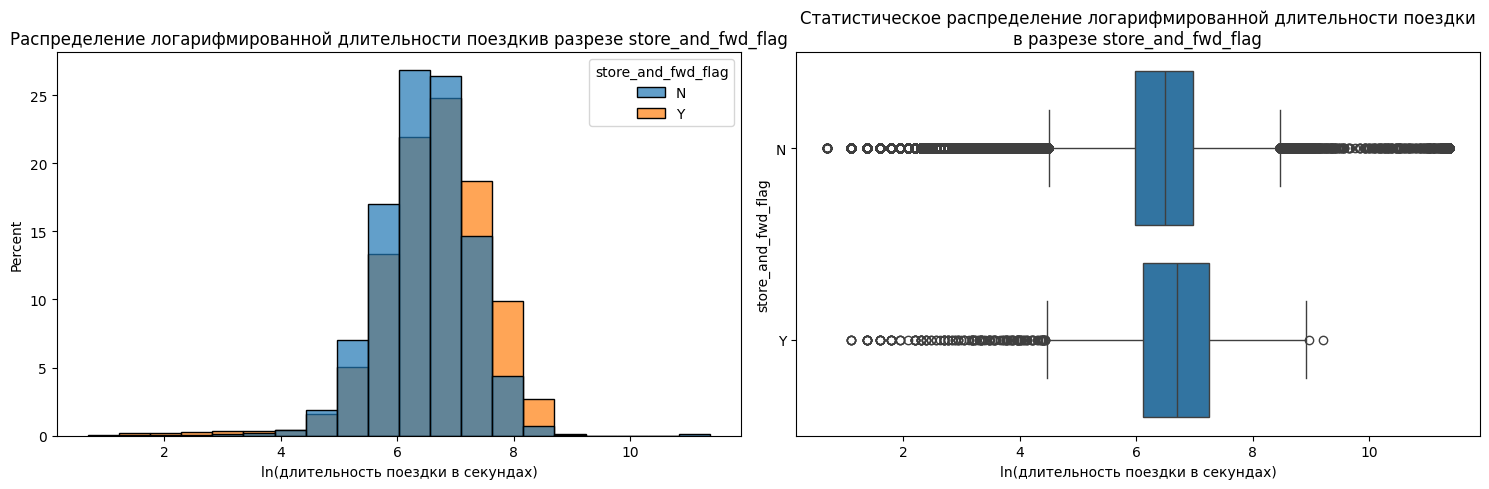

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
histplot = sns.histplot(data=taxi_data, x='trip_duration_log', ax=axes[0], alpha=0.7, bins=20, kde=False, hue='store_and_fwd_flag', common_norm=False, stat='percent')
histplot.set_title('Распределение логарифмированной длительности поездкив разрезе store_and_fwd_flag')
histplot.set_xlabel('ln(длительность поездки в секундах)')
boxplot = sns.boxplot(data=taxi_data, x='trip_duration_log', y='store_and_fwd_flag', ax=axes[1], orient='h')
boxplot.set_title('Статистическое распределение логарифмированной длительности поездки' + '\n' + 'в разрезе store_and_fwd_flag')
boxplot.set_xlabel('ln(длительность поездки в секундах)')
plt.tight_layout() #выравнивание графиков

In [36]:
taxi_data['store_and_fwd_flag'].value_counts(True)

store_and_fwd_flag
N    0.994486
Y    0.005514
Name: proportion, dtype: float64

Поездок с флагом Y очень мало, всего пол процента. Но такие поездкт длятся дольше.

Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

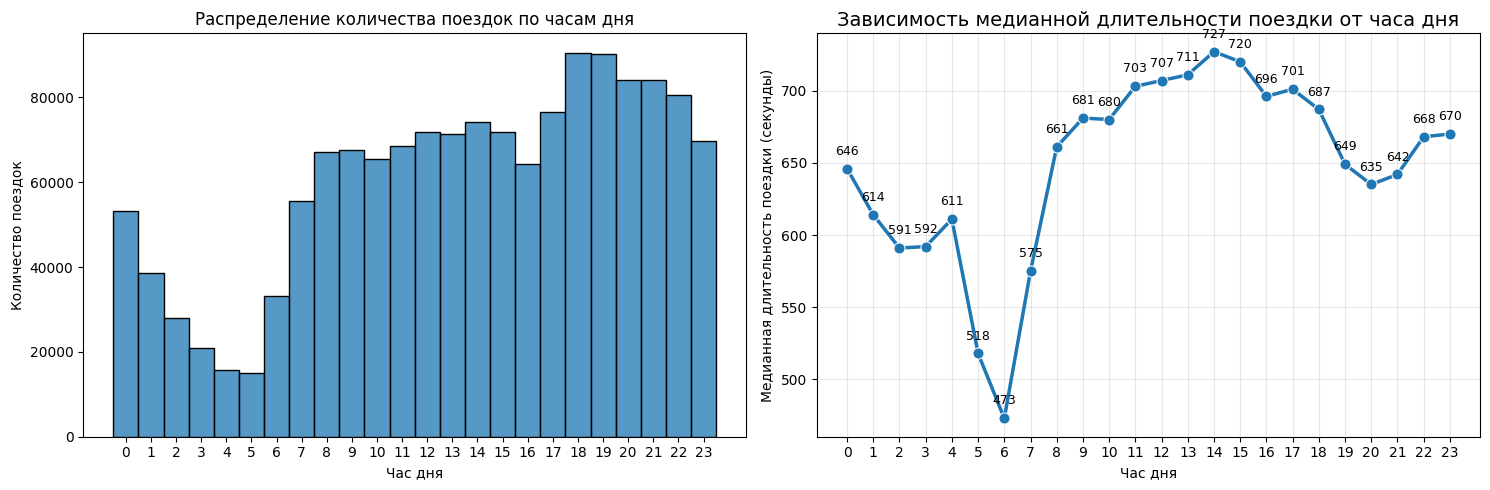

<Figure size 640x480 with 0 Axes>

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма из исходных данных
histplot = sns.histplot(data=taxi_data, x='pickup_hour', ax=axes[0], bins=24, binrange=(-0.5, 23.5))
histplot.set_title('Распределение количества поездок по часам дня')
histplot.set_xlabel('Час дня')
histplot.set_ylabel('Количество поездок')
histplot.set_xticks(range(0, 24))  # Все часы от 0 до 23

# Боксплот для дополнительной информации
hourly_median = taxi_data.groupby('pickup_hour')['trip_duration'].median().reset_index()

lineplot = sns.lineplot(data=hourly_median, x='pickup_hour', y='trip_duration', 
                       marker='o', linewidth=2.5, markersize=8, ax=axes[1])
plt.title('Зависимость медианной длительности поездки от часа дня', fontsize=14)
plt.xlabel('Час дня')
plt.ylabel('Медианная длительность поездки (секунды)')
plt.grid(True, alpha=0.3)

# Добавляем подписи значений
for i, row in hourly_median.iterrows():
    plt.annotate(f"{row['trip_duration']:.0f}", 
                (row['pickup_hour'], row['trip_duration']),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
# Подписываем каждый час на оси X
plt.xticks(range(0, 24))  # Все часы от 0 до 23
plt.tight_layout()
plt.show()

plt.tight_layout()

Видим, что реже всего такси заказывают в 4-5 часов утра. И продолжительность поездок в утренние часы наименьшая, скорее всего  в это время нет пробок.
В районе обеда медианная длительность поездки наибольшая.

Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.


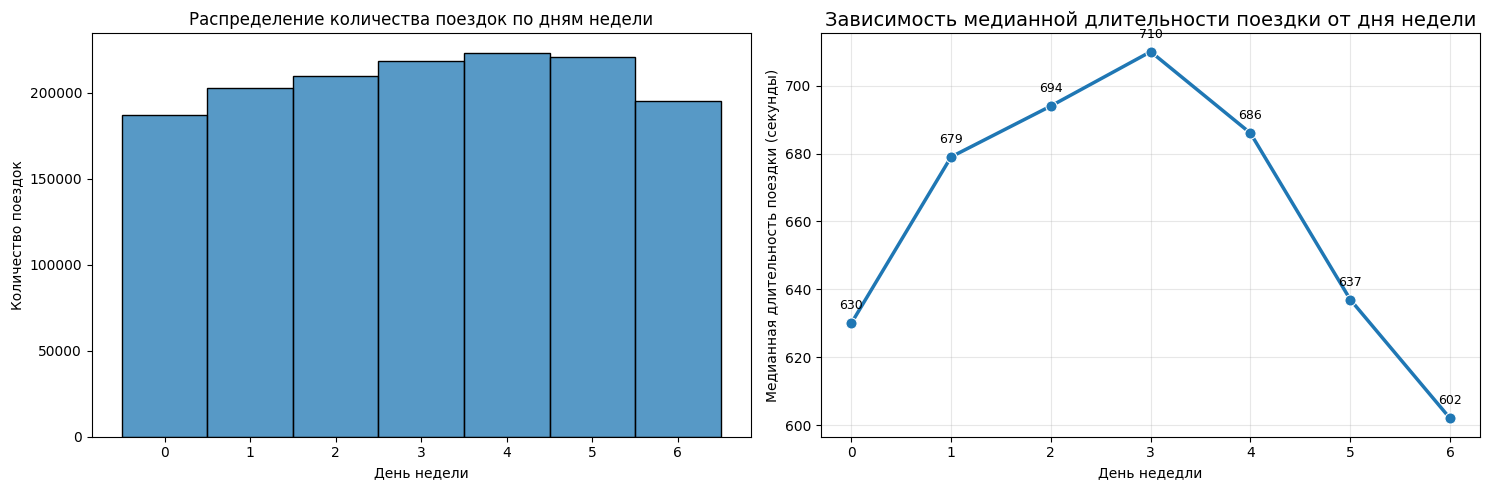

<Figure size 640x480 with 0 Axes>

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма из исходных данных
histplot = sns.histplot(data=taxi_data, x='pickup_day_of_week', ax=axes[0], bins=7, binrange=(-0.5, 6.5))
histplot.set_title('Распределение количества поездок по дням недели')
histplot.set_xlabel('День недели')
histplot.set_ylabel('Количество поездок')
histplot.set_xticks(range(0, 7))  # Все дни

# Боксплот для дополнительной информации
hourly_median = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median().reset_index()

lineplot = sns.lineplot(data=hourly_median, x='pickup_day_of_week', y='trip_duration', 
                       marker='o', linewidth=2.5, markersize=8, ax=axes[1])
plt.title('Зависимость медианной длительности поездки от дня недели', fontsize=14)
plt.xlabel('День недедли')
plt.ylabel('Медианная длительность поездки (секунды)')
plt.grid(True, alpha=0.3)

# Добавляем подписи значений
for i, row in hourly_median.iterrows():
    plt.annotate(f"{row['trip_duration']:.0f}", 
                (row['pickup_day_of_week'], row['trip_duration']),
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
# Подписываем каждый час на оси X
plt.xticks(range(0, 7))  # Все часы от 0 до 23
plt.tight_layout()
plt.show()

plt.tight_layout()

Больше всего поездок совершается в пятницу, но наибольшая медианная длительность поездок в четверг, а наименьшая в воскресенье.

Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы, по столбцам - дни недели, а в ячейках - медианная длительность поездки. 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

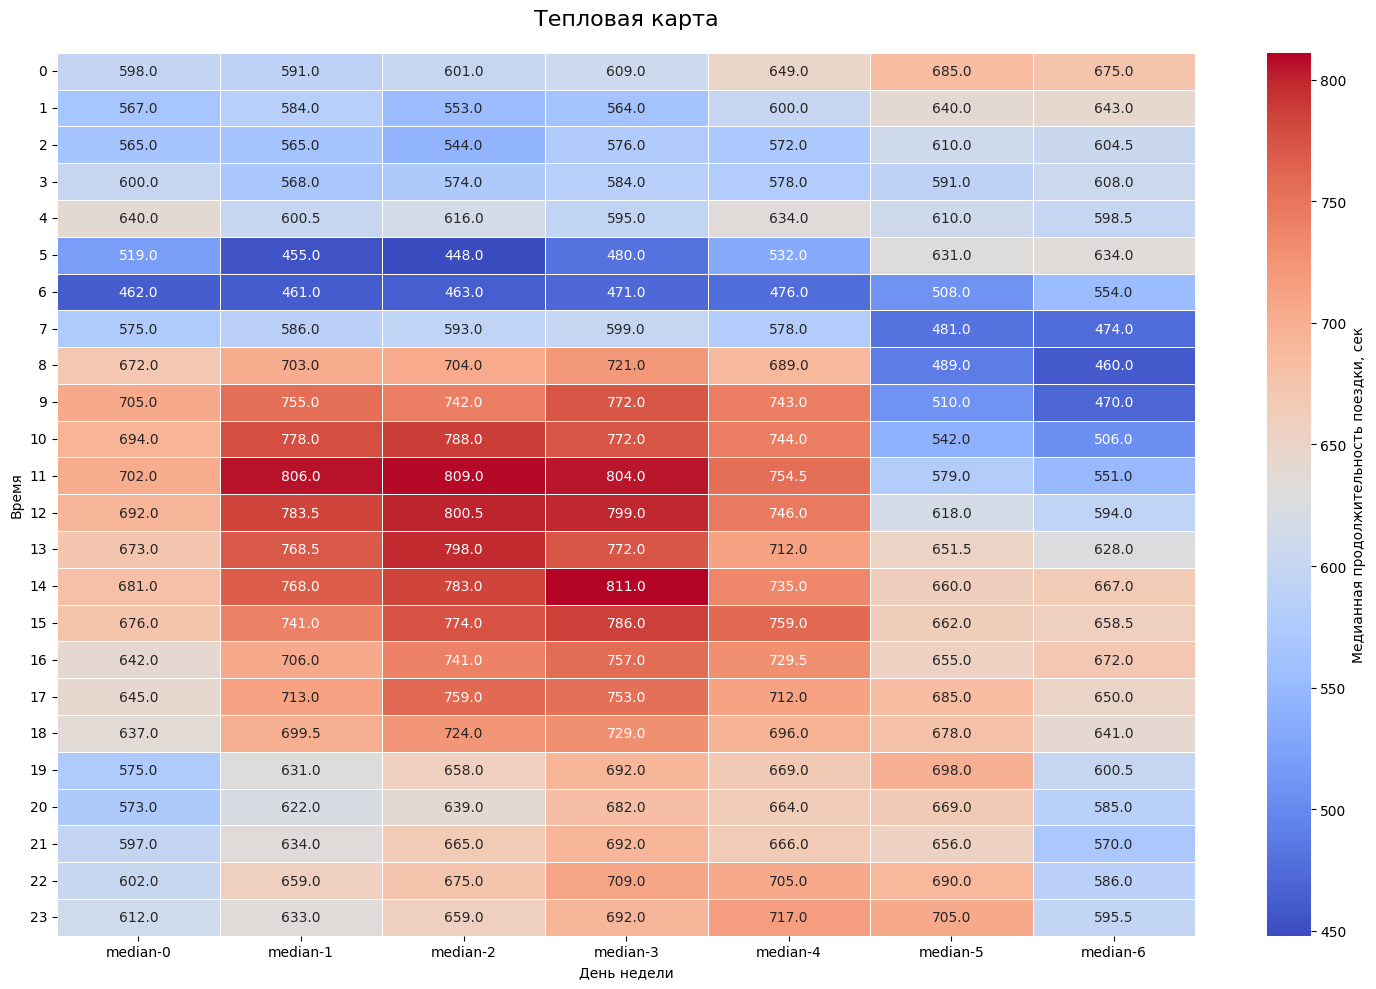

In [39]:
pivot = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc=['median'],
    fill_value=0
)

fig, ax = plt.subplots(figsize=(15, 10))
heatmap = sns.heatmap(
    pivot,
    cmap='coolwarm',          # Цветовая схема
    annot=True,              # Показать значения в ячейках
    fmt='.1f',               # Формат чисел (1 знак после запятой)
    linewidths=0.5,          # Линии между ячейками
    cbar_kws={'label': 'Медианная продолжительность поездки, сек'}  # Подпись цветовой шкалы
)
heatmap.set_title('Тепловая карта', fontsize=16, pad=20);
heatmap.set_xlabel('День недели')
heatmap.set_ylabel('Время')
plt.xticks(rotation=0)      # Поворот подписей на оси X
plt.yticks(rotation=0)       # Выровнять подписи на оси Y

plt.tight_layout()

Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.  
Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

Построим две диаграммы рассеяния:
* первая будет иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая - географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Ограничимся визуализацией только тех поездок, которые находятся в пределах Нью-Йорка:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 


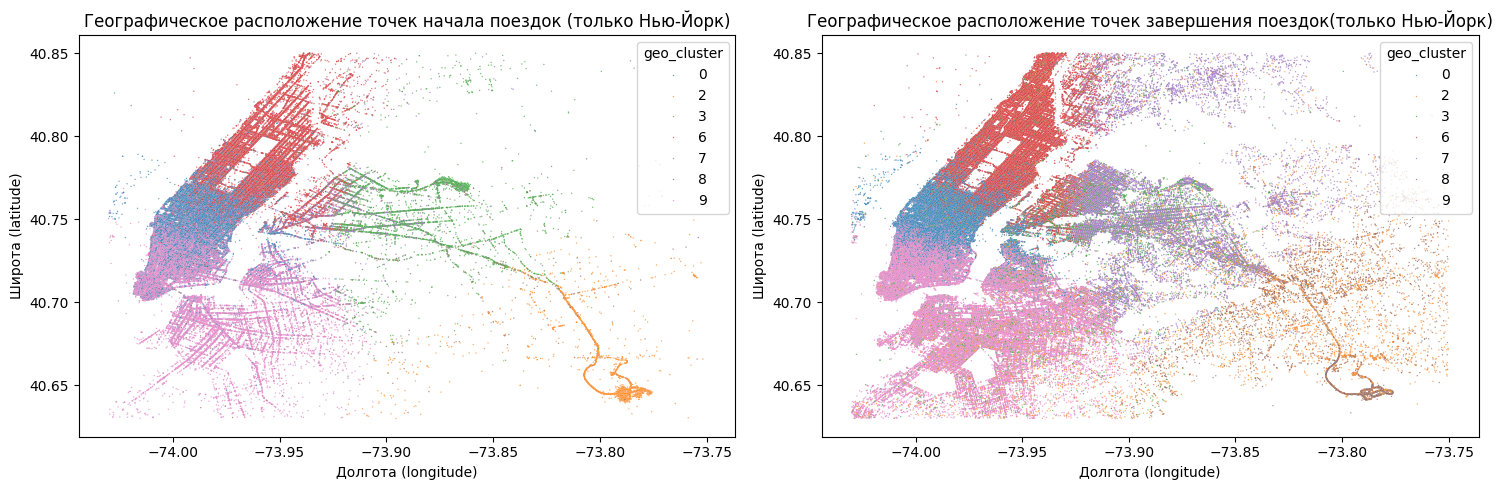

In [40]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Создаем маски для точек начала и окончания поездок
mask_pickup = (
    (taxi_data['pickup_longitude'].between(city_long_border[0], city_long_border[1])) & 
    (taxi_data['pickup_latitude'].between(city_lat_border[0], city_lat_border[1]))
    )

mask_dropoff = (
    (taxi_data['dropoff_longitude'].between(city_long_border[0], city_long_border[1])) & 
    (taxi_data['dropoff_latitude'].between(city_lat_border[0], city_lat_border[1])
     ))


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# Точки начала поездок
scatter_pickup = sns.scatterplot(
    data=taxi_data[mask_pickup], 
    x='pickup_longitude',
    y='pickup_latitude', 
    hue='geo_cluster', # Расцветка по кластерам
    palette='tab10',         # Палитра для 10 кластеров
    s=1,    # Уменьшение размера точек
    alpha=0.7, # Полупрозрачность для лучшего отображения плотности
    ax=axes[0]
)
scatter_pickup.set_title('Географическое расположение точек начала поездок (только Нью-Йорк)')
scatter_pickup.set_xlabel('Долгота (longitude)')
scatter_pickup.set_ylabel('Широта (latitude)')

# Точки завершения поездок
scatter_dropoff = sns.scatterplot(
    data=taxi_data[mask_dropoff], 
    x='dropoff_longitude', 
    y='dropoff_latitude', 
    hue='geo_cluster',       # Расцветка по кластерам
    palette='tab10',         # Та же палитра для консистентности
    s=1,                     # Уменьшение размера точек
    alpha=0.7,               # Полупрозрачность
    ax=axes[1]
)
scatter_dropoff.set_title('Географическое расположение точек завершения поездок(только Нью-Йорк)')
scatter_dropoff.set_xlabel('Долгота (longitude)')
scatter_dropoff.set_ylabel('Широта (latitude)')
plt.tight_layout() #выравнивание графиков

Можно заметить, что точки начала поездок имеют меньший разброс, то есть люди чаще уезжают из определенных мест. Можно предположить, что чаще люди еузжают из центра на окраины домой, чем наоборот (из дома в центр).

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде, поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [88]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [42]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642


Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

Уникальным для каждой поездки является её идентификатор — столбец id. Он никак не связан с длительностью поездки и не имеет значения при её прогнозировании.  
В наших данных утечку создаёт признак dropoff_datetime — зафиксированное время остановки счётчика. Начиная поездку, мы никак не можем точно знать, когда она закончится, ведь мы как раз и пытаемся предсказать время окончания поездки.



In [43]:
drop_columns = ['id', 'dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 25)


In [44]:
train_data.nunique()

vendor_id                   2
pickup_datetime       1379849
passenger_count            10
pickup_longitude        23014
pickup_latitude         45219
dropoff_longitude       33801
dropoff_latitude        62503
store_and_fwd_flag          2
trip_duration            7413
pickup_date               182
pickup_hour                24
pickup_day_of_week          7
pickup_holiday              2
total_distance         197214
total_travel_time       19438
number_of_steps            43
haversine_distance    1451907
direction             1451647
geo_cluster                10
temperature               124
visibility                 17
wind speed                 22
precip                     28
events                      4
trip_duration_log        7413
dtype: int64

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [45]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

In [46]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1 )


Создадим таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставим в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В параметре handle_unknown установим значение 'ignore'. Это позволит коду отработать без ошибок в случае появления в тестовой выборке значений, отсутствующих в обучающей выборке.

In [49]:
# 1. Выбираем категориальные колонки для кодирования
categorical_columns = ['pickup_day_of_week', 'geo_cluster','events']

# 2. Создаем кодировщик с dense output
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# 3. Применяем кодировщик к категориальным данным
data_onehot2 = one_hot_encoder.fit_transform(train_data[categorical_columns])

# 4. Создаем DataFrame с закодированными признаками
encoded_columns = one_hot_encoder.get_feature_names_out(categorical_columns)
data_onehot = pd.DataFrame(data_onehot2, columns=encoded_columns)

print("\nЗакодированные признаки:")
print(f"Размерность: {data_onehot.shape}")


Закодированные признаки:
Размерность: (1458233, 18)


In [50]:
data_onehot

,pickup_day_of_week_1,pickup_day_of_week_2,pickup_day_of_week_3,pickup_day_of_week_4,pickup_day_of_week_5,pickup_day_of_week_6,geo_cluster_1,geo_cluster_2,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458228,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1458229,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458230,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1458231,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Добавим полученную таблицу с закодированными признаками:

In [51]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(categorical_columns, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [52]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [53]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. 

In [54]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
 
selector.get_feature_names_out()

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday',
       'total_distance', 'total_travel_time', 'number_of_steps',
       'haversine_distance', 'temperature', 'pickup_day_of_week_1',
       'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5',
       'pickup_day_of_week_6', 'geo_cluster_2', 'geo_cluster_3',
       'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8'], dtype=object)

In [55]:
cols_to_study = selector.get_feature_names_out()
X_train = X_train[cols_to_study]
X_valid = X_valid[cols_to_study]

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то заранее позаботимся о масштабировании факторов. 


In [56]:
from sklearn.preprocessing import MinMaxScaler

# Выполним масштабирование признаков
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Преобразуем обратно в DataFrame для удобства
columns = X_train.columns
X_train_scaled = pd.DataFrame(X_train_scaled, columns=columns, index=X_train.index)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=columns, index=X_valid.index)


In [57]:
X_train_scaled.to_csv('X_train_scaled.csv')
X_valid_scaled.to_csv('X_valid_scaled.csv')

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1)$$



Построим модель линейной регрессии на обучающей выборке (факторы уже нормализованы, целевая переменная используетсяе в логарифмическом масштабе).


In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
# Создаем модель
LR = LinearRegression()

#Обучаем модель
LR.fit(X_train_scaled, y_train_log)

#Делаем предсказания
y_train_log_pred_lr = LR.predict(X_train_scaled)
y_valid_log_pred_lr = LR.predict(X_valid_scaled)

#Выводим значения метрики 
print('Train: {:.2f}'.format(root_mean_squared_error(y_train_log, y_train_log_pred_lr)))
print('Test: {:.2f}'.format(root_mean_squared_error(y_valid_log, y_valid_log_pred_lr)))

Train: 0.54
Test: 0.54


Сгенерируем полиномиальные признаки 2-ой степени и построим модель полиномиальной регрессии 2-ой степени на обучающей выборке

In [59]:
#Создаём генератор полиномиальных признаков
#poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
#X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
#X_valid_poly = poly.transform(X_valid_scaled)
#Выводим результирующие размерности таблиц
#print(X_train_poly.shape)
#print(X_valid_poly.shape)

#Создаём объект класса LinearRegression
#lr_model_poly = LinearRegression()

#Обучаем модель по МНК
#lr_model_poly.fit(X_train_poly, y_train_log)

#Делаем предсказание для тренировочной выборки
#y_train_predict_poly = lr_model_poly.predict(X_train_poly)
#y_valid_predict_poly = lr_model_poly.predict(X_valid_poly)

#Выводим значения метрики 
#print('Train: {:.2f}'.format(root_mean_squared_error(y_train_log, y_train_predict_poly)))
#print('Test: {:.2f}'.format(root_mean_squared_error(y_valid_log, y_valid_predict_poly)))

Для работы кода не хватило оперативной памяти, поэтому был выполнен в Google Colab. Результаты: 
Train: 0.47
Test: 0.69
Налицо переобучение модели, нужно применять регуляризацию.

Построим модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке

In [60]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
# ridge_lr_poly = linear_model.Ridge(alpha=10)
#Обучаем модель
#ridge_lr_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
#y_train_predict_poly = ridge_lr_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
#y_valid_predict_poly = ridge_lr_poly.predict(X_valid_poly)
#Рассчитываем коэффициент детерминации для двух выборок
#print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
#print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_valid_predict_poly)))

Аналогично, код был выполнен в Google Colab. Результаты:
Train RMSE: 0.481
Test RMSE: 0.485
Переобучения не наблюдается.

Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке


In [61]:
from sklearn.tree import DecisionTreeRegressor

# Создаем модель
tree_model = DecisionTreeRegressor(random_state=42)

#Обучаем модель
tree_model.fit(X_train_scaled, y_train_log)

#Делаем предсказания
y_train_log_pred_tree_model = tree_model.predict(X_train_scaled)
y_valid_log_pred_tree_model = tree_model.predict(X_valid_scaled)

#Выводим значения метрики 
print('Train RMSE: {:.2f}'.format(root_mean_squared_error(y_train_log, y_train_log_pred_tree_model)))
print('Valid RMSE: {:.2f}'.format(root_mean_squared_error(y_valid_log, y_valid_log_pred_tree_model)))

Train RMSE: 0.00
Valid RMSE: 0.56


Конечно получили переобучение, т.к. дерево делилось до полного уменьшения энтропии, необходимо задавать его максимальную глубину и другие параметры.
Для интереса попробуем перебрать все возможные варианты глубины дерева решений в диапазоне от 7 до 20 и найти оптимальную глубину дерева.

In [ ]:
# Диапазон глубин для перебора
max_depths = range(7, 21)  # от 7 до 20 включительно

# Списки для хранения метрик
train_rmse_scores = []
valid_rmse_scores = []

print("Перебор глубины дерева:")
print("Глубина | Train RMSE | Valid RMSE")
print("-" * 35)

# Перебираем все глубины
for depth in max_depths:
    # Создаем и обучаем модель
    tree_model = DecisionTreeRegressor(
        max_depth=depth,
        random_state=42
    )
    tree_model.fit(X_train_scaled, y_train_log)
    
    # Предсказания
    y_train_pred = tree_model.predict(X_train_scaled)
    y_valid_pred = tree_model.predict(X_valid_scaled)
    
    # Вычисляем RMSE
    train_rmse = root_mean_squared_error(y_train_log, y_train_pred)
    valid_rmse = root_mean_squared_error(y_valid_log, y_valid_pred)
    
    train_rmse_scores.append(train_rmse)
    valid_rmse_scores.append(valid_rmse)
    
    print(f"{depth:7} | {train_rmse:10.4f} | {valid_rmse:10.4f}")

# Находим оптимальную глубину
# Ищем минимальное значение RMSE на валидации
optimal_depth_idx = np.argmin(valid_rmse_scores)
optimal_depth = max_depths[optimal_depth_idx]
optimal_valid_rmse = valid_rmse_scores[optimal_depth_idx]

print(f"\nОптимальная глубина: {optimal_depth}")
print(f"RMSE на валидации при оптимальной глубине: {optimal_valid_rmse:.4f}")

Перебор глубины дерева:
Глубина | Train RMSE | Valid RMSE
-----------------------------------
      7 |     0.4448 |     0.4471
      8 |     0.4370 |     0.4408
      9 |     0.4299 |     0.4356
     10 |     0.4224 |     0.4312
     11 |     0.4146 |     0.4298
     12 |     0.4059 |     0.4302
     13 |     0.3956 |     0.4324
     14 |     0.3838 |     0.4369
     15 |     0.3704 |     0.4448
     16 |     0.3557 |     0.4531
     17 |     0.3395 |     0.4619
     18 |     0.3221 |     0.4737
     19 |     0.3034 |     0.4830
     20 |     0.2845 |     0.4938

Оптимальная глубина: 11
RMSE на валидации при оптимальной глубине: 0.4298


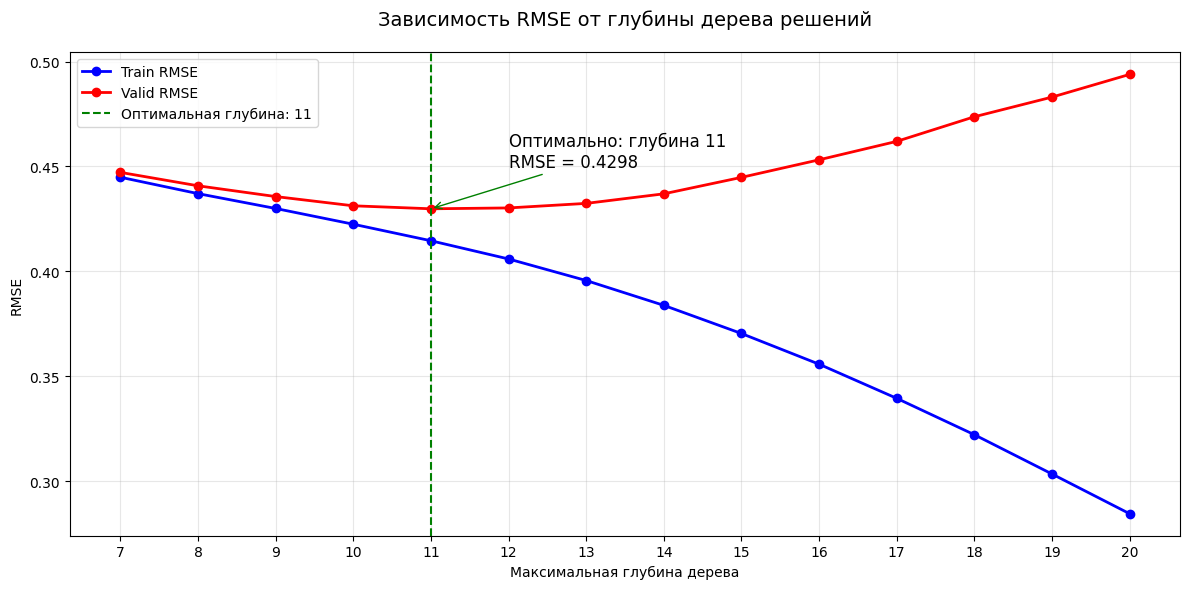

In [92]:
# Создаем график
plt.figure(figsize=(12, 6))

# График для тренировочной выборки
plt.plot(max_depths, train_rmse_scores, 'o-', linewidth=2, label='Train RMSE', color='blue')

# График для валидационной выборки
plt.plot(max_depths, valid_rmse_scores, 'o-', linewidth=2, label='Valid RMSE', color='red')

# Отмечаем оптимальную глубину
plt.axvline(x=optimal_depth, color='green', linestyle='--', 
            label=f'Оптимальная глубина: {optimal_depth}')

# Настройки графика
plt.title('Зависимость RMSE от глубины дерева решений', fontsize=14, pad=20)
plt.xlabel('Максимальная глубина дерева')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Добавляем аннотацию с оптимальным значением
plt.annotate(f'Оптимально: глубина {optimal_depth}\nRMSE = {optimal_valid_rmse:.4f}', 
             xy=(optimal_depth, optimal_valid_rmse),
             xytext=(optimal_depth+1, optimal_valid_rmse+0.02),
             arrowprops=dict(arrowstyle='->', color='green'),
             fontsize=12, ha='left')

plt.xticks(max_depths)
plt.tight_layout()
plt.show()

Обучим на лучших параметрах.

In [93]:
# Создаем модель
tree_model = DecisionTreeRegressor(max_depth=11,
                                    random_state=42)

#Обучаем модель
tree_model.fit(X_train_scaled, y_train_log)

#Делаем предсказания
y_train_log_pred_tree_model = tree_model.predict(X_train_scaled)
y_valid_log_pred_tree_model = tree_model.predict(X_valid_scaled)

#Выводим значения метрики 
print('Train RMSE: {:.2f}'.format(root_mean_squared_error(y_train_log, y_train_log_pred_tree_model)))
print('Valid RMSE: {:.2f}'.format(root_mean_squared_error(y_valid_log, y_valid_log_pred_tree_model)))

Train RMSE: 0.41
Valid RMSE: 0.43


Отлично, мы ушли от переобучения. Конечно это не итоговый результат, можно продолжать оптимизировать модель подбирая оптимильные гиперпараметры с помощью GridSearch, Optuna и др, но лучше построим более сложные ансамблевые модели.

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к ансамблевым алгоритмам. 

### **Построим модель случайного леса**


In [66]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42)

#Обучаем модель
rf.fit(X_train_scaled, y_train_log)

#Делаем предсказания
y_train_log_pred_rf= rf.predict(X_train_scaled)
y_valid_log_pred_rf = rf.predict(X_valid_scaled)

#Выводим значения метрики 
print('Train RMSE: {:.2f}'.format(root_mean_squared_error(y_train_log, y_train_log_pred_rf)))
print('Valid RMSE: {:.2f}'.format(root_mean_squared_error(y_valid_log, y_valid_log_pred_rf)))

Train RMSE: 0.40
Valid RMSE: 0.41


### **Теперь построим модель градиентного бустинга над деревьями решений** (GradientBoostingRegressor)


In [67]:
# Создаем модель
gbr = ensemble.GradientBoostingRegressor(
                    learning_rate = 0.5, # темп обучения   
                    n_estimators = 100, #количество деревьев в ансамбле
                    max_depth = 6, #максимальная глубина дерева
                    min_samples_split=30,
                    random_state = 42,
                    )

#Обучаем модель
gbr.fit(X_train_scaled, y_train_log)

#Делаем предсказания
y_train_log_pred_gbr= gbr.predict(X_train_scaled)
y_valid_log_pred_gbr = gbr.predict(X_valid_scaled)

#Выводим значения метрики 
print('Train RMSE: {:.2f}'.format(root_mean_squared_error(y_train_log, y_train_log_pred_gbr)))
print('Valid RMSE: {:.2f}'.format(root_mean_squared_error(y_valid_log, y_valid_log_pred_gbr)))

Train RMSE: 0.37
Valid RMSE: 0.39


Построим столбчатую диаграмму коэффициентов значимости каждого из факторов.

In [68]:
# 1. Создаем DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({
    'feature': X_train_scaled.columns,  # названия признаков
    'importance': gbr.feature_importances_  # важность из модели
})

# 2. Сортируем по убыванию важности
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

print("Топ-10 самых важных признаков:")
print(feature_importance_df.head(10))

Топ-10 самых важных признаков:
                 feature  importance
9         total_distance    0.629706
10     total_travel_time    0.186361
7            pickup_hour    0.059159
5       dropoff_latitude    0.027876
12    haversine_distance    0.026169
4      dropoff_longitude    0.014197
2       pickup_longitude    0.011828
3        pickup_latitude    0.011057
19  pickup_day_of_week_6    0.007539
11       number_of_steps    0.005861


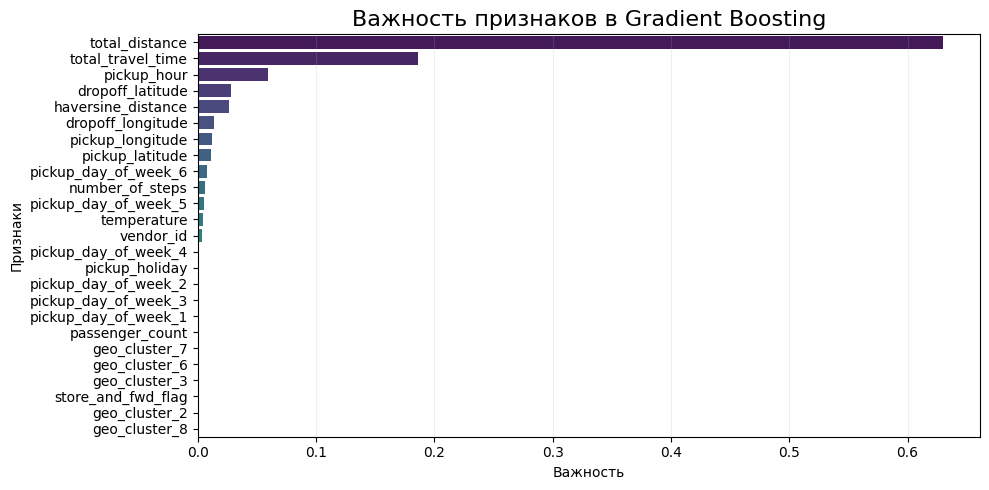

In [69]:
fig, ax = plt.subplots(figsize=(10, 5))  # Создаем figure и axes

# Строим график
sns.barplot(data=feature_importance_df, 
            y='feature', 
            x='importance', 
            palette='viridis',
            ax=ax) 

# Настраиваем через объект axes
ax.set_title('Важность признаков в Gradient Boosting', fontsize=16)
ax.set_xlabel('Важность')
ax.set_ylabel('Признаки')
ax.grid(True, axis='x', alpha=0.2, linestyle='-')
plt.tight_layout()
plt.show()

### **Попробуем модель XGBoost**

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [94]:
# Преобразуем numpy array в список
feature_names_list = cols_to_study.tolist()
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_log, feature_names=feature_names_list)
dvalid = xgb.DMatrix(X_valid_scaled, label=y_valid_log, feature_names=feature_names_list)


In [95]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.73993	valid-rmse:0.74194
[10]	train-rmse:0.49089	valid-rmse:0.49347
[20]	train-rmse:0.44082	valid-rmse:0.44368
[30]	train-rmse:0.42639	valid-rmse:0.42943
[40]	train-rmse:0.41914	valid-rmse:0.42234
[50]	train-rmse:0.41386	valid-rmse:0.41740
[60]	train-rmse:0.40949	valid-rmse:0.41336
[70]	train-rmse:0.40639	valid-rmse:0.41065
[80]	train-rmse:0.40406	valid-rmse:0.40865
[90]	train-rmse:0.40231	valid-rmse:0.40712
[100]	train-rmse:0.40051	valid-rmse:0.40569
[110]	train-rmse:0.39931	valid-rmse:0.40469
[120]	train-rmse:0.39767	valid-rmse:0.40335
[130]	train-rmse:0.39646	valid-rmse:0.40237
[140]	train-rmse:0.39530	valid-rmse:0.40149
[150]	train-rmse:0.39393	valid-rmse:0.40038
[160]	train-rmse:0.39299	valid-rmse:0.39964
[170]	train-rmse:0.39213	valid-rmse:0.39902
[180]	train-rmse:0.39150	valid-rmse:0.39861
[190]	train-rmse:0.39070	valid-rmse:0.39818
[200]	train-rmse:0.38989	valid-rmse:0.39760
[210]	train-rmse:0.38930	valid-rmse:0.39728
[220]	train-rmse:0.38886	valid-rmse:0.39709

Предскажем целевой признак на новых данных:

In [96]:
#Делаем предсказания
y_train_log_pred_xgb= model.predict(dtrain)
y_valid_log_pred_xgb = model.predict(dvalid)

#Выводим значения метрики 
print('Train RMSE: {:.2f}'.format(root_mean_squared_error(y_train_log, y_train_log_pred_xgb)))
print('Valid RMSE: {:.2f}'.format(root_mean_squared_error(y_valid_log, y_valid_log_pred_xgb)))


Train RMSE: 0.38
Valid RMSE: 0.39


Определим коэффициенты важности факторов:

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

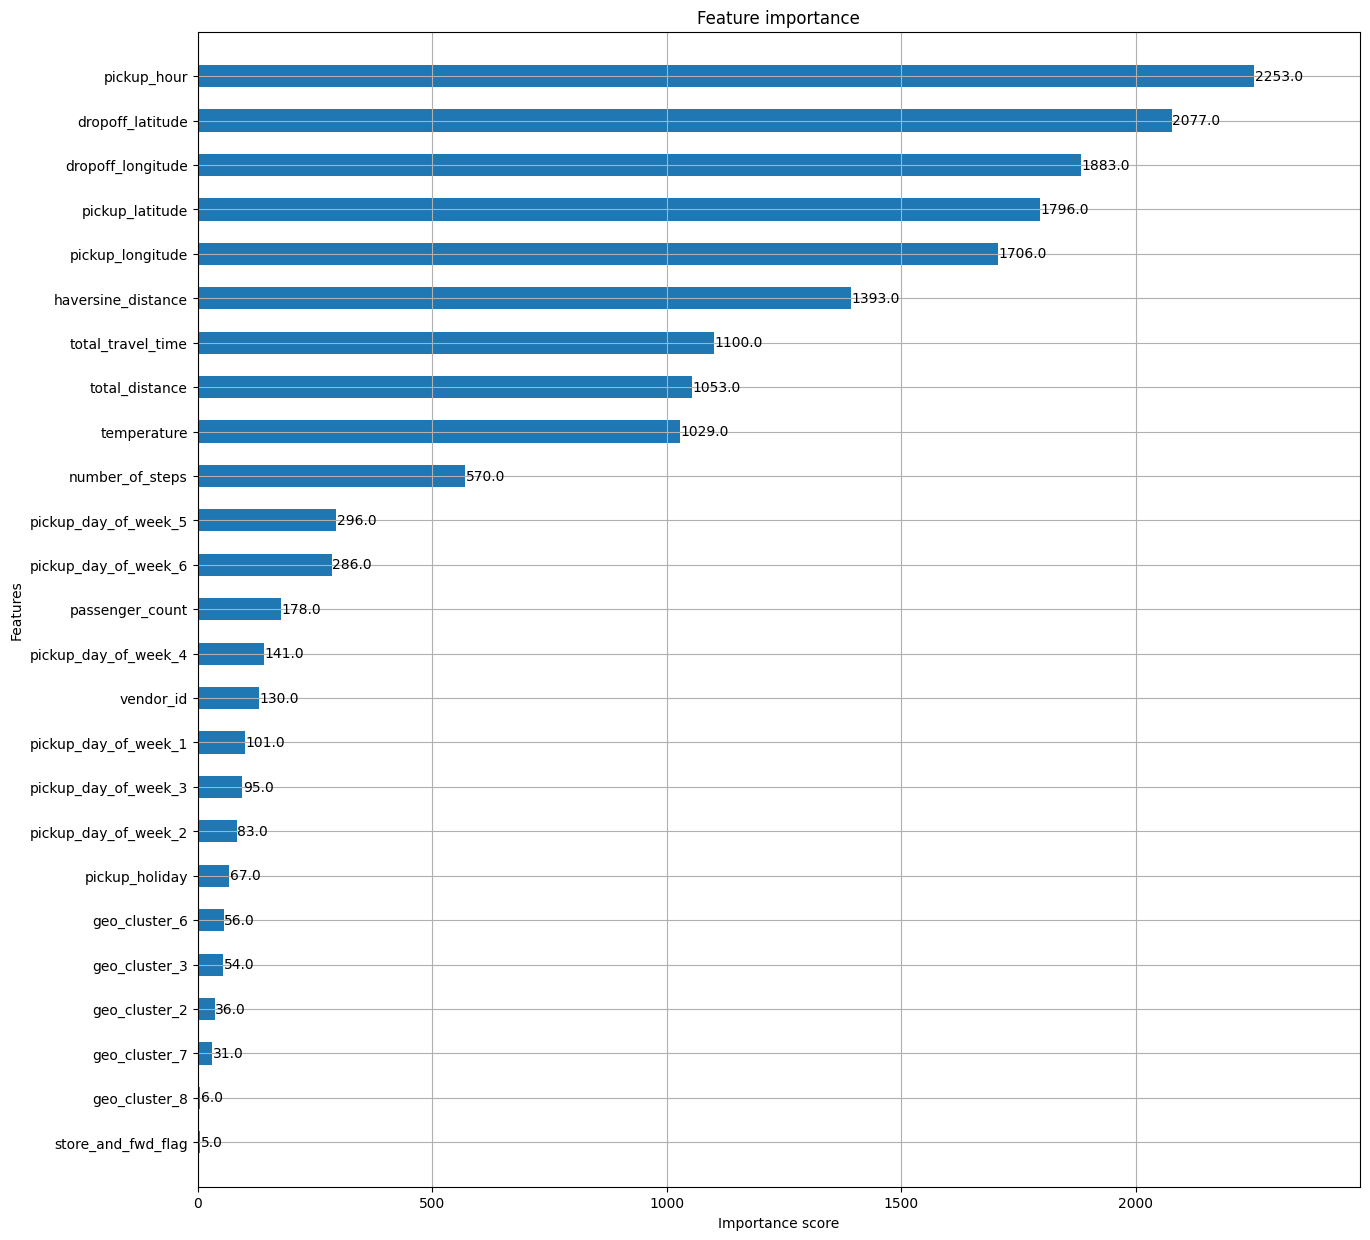

In [83]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

Интересно, что для модели градиентного бустинга и XGBoost наиболее важные признаки - разные.

Для лучшей модели рассчитаем медианную абсолютную ошибку (MeAE) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведем в минуты.


In [90]:
y_valid_no_log = np.exp(y_valid_log) - 1
y_valid_no_log_pred_gbx = np.exp(y_valid_log_pred_xgb) - 1
print('Valid MeAE: {:.1f}'.format((metrics.median_absolute_error(y_valid_no_log, y_valid_no_log_pred_gbx))/60))

Valid MeAE: 1.8


MedAE = 1.8 минуты — это прекрасный результат для задачи прогнозирования времени поездки. Это означает, что для половины поездок в валидационной выборке ошибка предсказания составляет меньше 1.8 минут, а для другой половины — больше.

Почему это хорошая метрика для задачи:
Устойчивость к выбросам. В данных о поездках могут быть аномально долгие поездки (пробки, неправильно введенный адрес и т.д.). MedAE, в отличие от MAE (средней абсолютной ошибки) и особенно RMSE, очень устойчива к таким выбросам. Она показывает типичную ошибку для "нормальной" поездки.

Финальный шаг - сделаем submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных.


In [71]:
test_data = pd.read_csv("data/test_data.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [72]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

test_data_onehot = one_hot_encoder.transform(test_data[categorical_columns])
column_names = one_hot_encoder.get_feature_names_out(categorical_columns)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(categorical_columns, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[cols_to_study]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [87]:
dtest = xgb.DMatrix(X_test_scaled, feature_names=feature_names_list)

In [ ]:
#Делаем предсказания
# Логарифмированное время поездки
y_test_log_pred_gbx= gbr.predict(dtest)
# Получаем нелогарифмированное время поездки
y_test_no_log_pred_gbx = np.exp(y_test_log_pred_gbx) - 1

После выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Переведем предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После этого создалим submission-файл в формате csv, отправим его на платформу Kaggle и посмотрим на результирующее значение метрики RMSLE на тестовой выборке.


In [ ]:
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_no_log_pred_gbx})
submission.to_csv('data/submission_gb.csv', index=False)

In [76]:
submission

,id,trip_duration
0,id3004672,853.652869
1,id3505355,527.956830
2,id1217141,369.979696
3,id2150126,1027.993521
4,id1598245,257.009052
...,...,...
625129,id3008929,366.284105
625130,id3700764,1150.829310
625131,id2568735,1737.287981
625132,id1384355,2258.673213


**Вывод**
Вывод: итак, в ходе работы были выполнены все этапы проекта.
Обработаны пропуски, выбросы. Рассмотрены статистические характеристики признаков, созданы новые признаки.
Построены визуализации для лучшего понимания зависимостей в данных.
Категориальные признаки были закодированы, из признаков в формате дат была получена доп. информация. Отобраны признаки для обучения модели. Признаки были стандартизированы. Обучающая выборка была разделена на тренировочную и валидационную. Т.к. все преобразования признаков для train/valid были выполнены в виде функций, это позволило легко преобразовать тестовую выборку для соответствия формату тренировочной.  
Основной метрикой качества решения поставленной задачи была RMSLE (Root Mean Squared Log Error), которая вычисляется на основе целевой переменной в логарифмическом масштабе.

В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
Были обучены модели:
* Линейной регрессии
* Деревья решений
* Случайного леса
* Градиентного бустинга над деревом решений
* XGBoost
Лучшие результаты по метрике Root Mean Squared Log Error показада модель XGBoost. Для последних двух моделей были определены наиболее важные признаки, и как мы убедились, для разных моделей разный топ признаков по важности.

При построении модели целевая переменная была логарифмирована, поэтому для оценки результата предсказания модели были возвращены обычный (не логарифмированный) масштаб и посчитана метрика медианной абсолютной ошибки (MeAE). Это хорошая метрика для данной задачи, т.к. имеет устойчивость к выбросам. В данных о поездках могут быть аномально долгие поездки (пробки, неправильно введенный адрес и т.д.). MedAE, в отличие от MAE (средней абсолютной ошибки) и особенно RMSE, очень устойчива к таким выбросам. Она показывает типичную ошибку для "нормальной" поездки.
MedAE = 1.8 минуты — это прекрасный результат для задачи прогнозирования времени поездки. Это означает, что для половины поездок в валидационной выборке ошибка предсказания составляет меньше 1.8 минут, а для другой половины — больше.
